# Control Systems Tutorial 
## Part B: Control tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import control as ct
from source.cablecar_model import cablecar_ode, cablecar_output
import source.eins_controller as controller

# System parameters 
M = 0.5; m1 = 5; m2 = 0.1; l = 2.0; g = 9.81; b1 = 2.0; b2 = 0.2; r = 0.02

cablecar_params = {
    "M": M,           # mass of the trolley
    "m1": m1,         # mass of the cable car
    "m2": m2,         # mass of pendulum rod
    "l": l,         # length of the suspension cable
    "g": g,         # gravitational acceleration
    "b1": b1,       # damping of the slider
    "b2": b2,       # damping of the cable car
    "r" : r         # ??
}

cablecar_sys = ct.nlsys(
    cablecar_ode, cablecar_output, name='cablecar',
    params=cablecar_params, states=['theta', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])
print(f"Stable steady state at x")
x0, u0 = [-0.1, 0.0, 0.0, 0.0], [0.0]
xeq, ueq = ct.find_operating_point(cablecar_sys, x0, u0)
cablecar_sys_linear = ct.linearize(cablecar_sys, xeq, ueq) 


Stable steady state at x


## Your overall task

As engineers at the EINS cable car company, your mission is to design a position control system for cable cars.

Your colleagues from Product Engineering have devised the following requirements for the control system:
- Reach the terminal position so that passengers can safely exit.
- Provide a pleasant cable car ride experience. Note: Cable cars are not roller coasters.
- Be efficient in terms of control power and do not lead to excessive wear of the actuator.

Although the product engineers did not specify it, remember that a control system that leads to an unstable system will not pass the testing stage.

### Manual tuning of PID

__Task:__ Manually tune a PID controller to control the position of the cable car.

#### System model 

First, we need to derive the transfer function of the linearized cable car model for the input force to output position.
This means we need to compute

$$ G(s)=c_{position}(sI-A)^{-1}b_{force} .$$

#### Analyze the transfer function:
*Transfer function*

In [2]:

cable_car_f2x= controller.siso_position(cablecar_sys_linear)
print(cable_car_f2x)


<TransferFunction>: sys[1]$indexed
Inputs (1): ['F']
Outputs (1): ['x']

  4.441e-16 s^3 + 1.818 s^2 + 0.1799 s + 8.915
  --------------------------------------------
     s^4 + 1.371 s^3 + 49.96 s^2 + 1.783 s


#### Define a PID controller by its transfer function

In [3]:
pid_sys = controller.pid_tf(10, 1, 3)
print(pid_sys)


<TransferFunction>: sys[2]
Inputs (1): ['e']
Outputs (1): ['u']

  4 s^2 + 10.1 s + 1
  ------------------
     0.1 s^2 + s


#### Design a first controller

*Hint:*
- $K_P \in [0.4, 0.8]$
- $K_I$ necessary?
- $K_D \in [5,10]$

In [4]:
pid = controller.pid_tf(0.5,0,10)
closed_sys = controller.close_siso_sys(cable_car_f2x, pid)


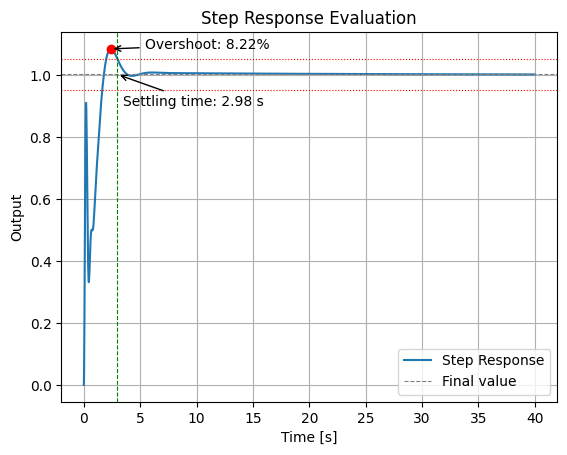

In [5]:
y=controller.evaluate_step_response(closed_sys)["y_out"]

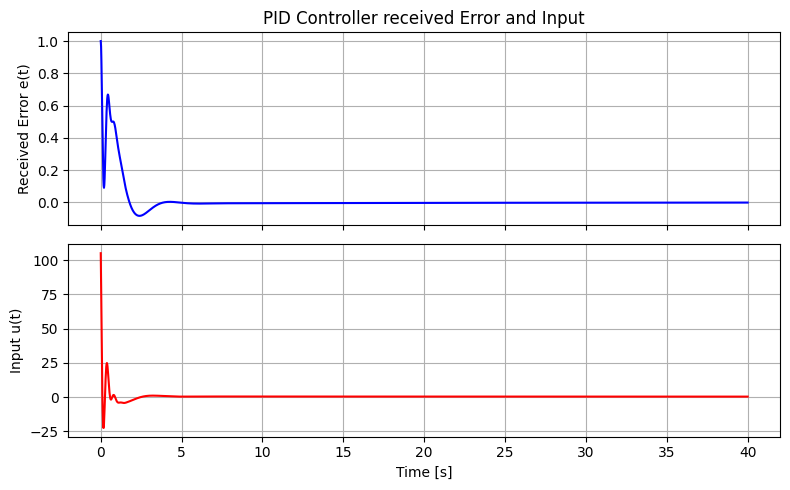

In [18]:
T, e = ct.forced_response(pid, controller.DEFAULT_TIMEPTS, 1 - y)
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

axs[0].plot(T, 1-y, 'b')
axs[0].set_ylabel("Received Error e(t)")
axs[0].grid(True)
axs[0].set_title("PID Controller received Error and Input")
axs[1].plot(T, e, 'r')
axs[1].set_ylabel("Input u(t)")
axs[1].set_xlabel("Time [s]")
axs[1].grid(True)

plt.tight_layout()
plt.show()

*Question:* Which influence does the constant $\tau$ have on the PD controller?

#### First test of PID position control

__Test case:__ Follow the position trajectory $p(t)$

$p(t) = \min(t,20),t\in[0,40]$

__Settling time:__ We define the settling time as $T_{settle} \in \arg \max t, \text{s.t.} \|x_{final} - x_{c,t}\|_1 \ge 0.01m$

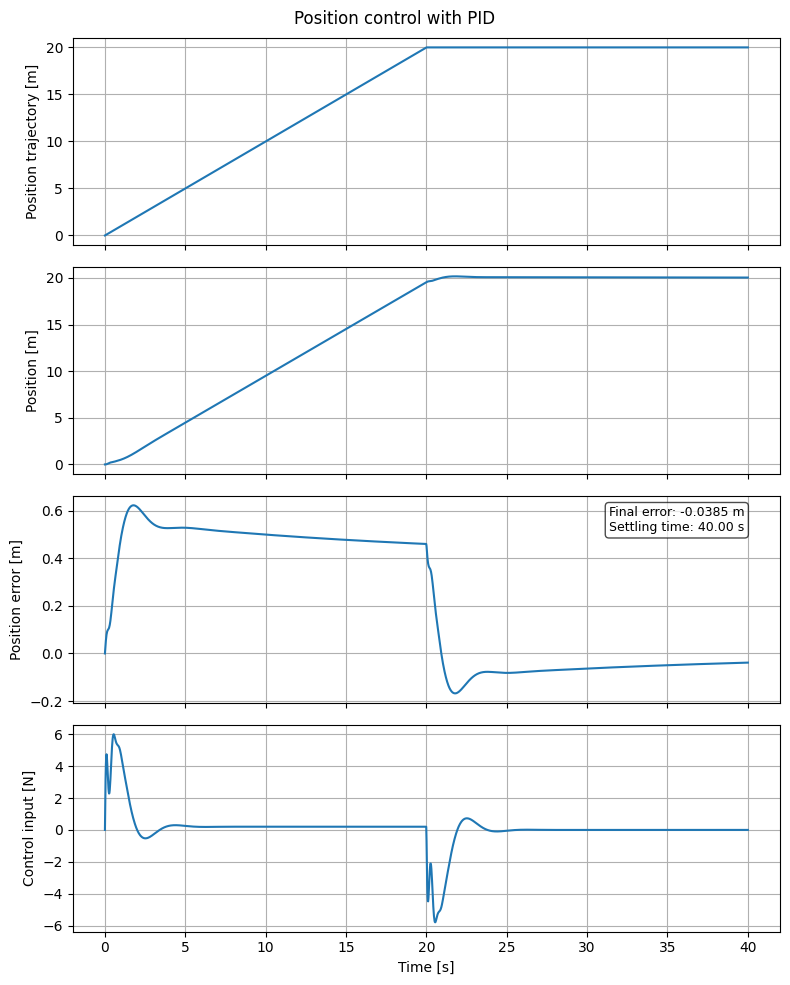

In [7]:
y_out, _ =controller.analyze_pid_control(cable_car_f2x,pid)

*Let us analyze the other states that are not controlled by the PID.*

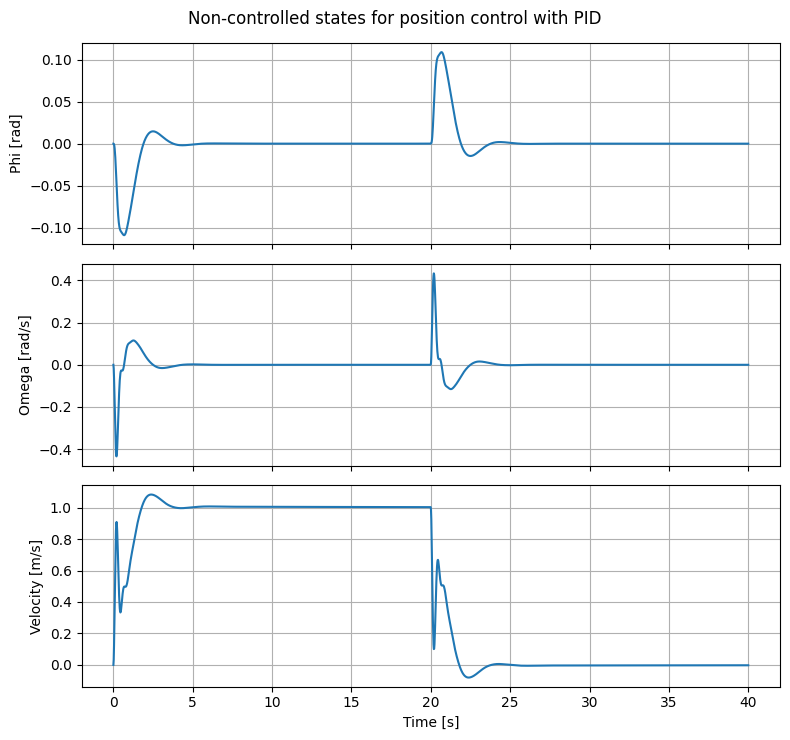

In [8]:
controller.analyze_pid_misc_states(pid,cablecar_sys_linear, controller.DEFAULT_POS_TRAJECTORY-y_out)

*Please mind the gap - PID Tuning again*: 
Maybe we indeeed need an $K_I > 0$...
Try:
- $K_P = 5$
- $K_I = 1$
- $K_D = 10$ 

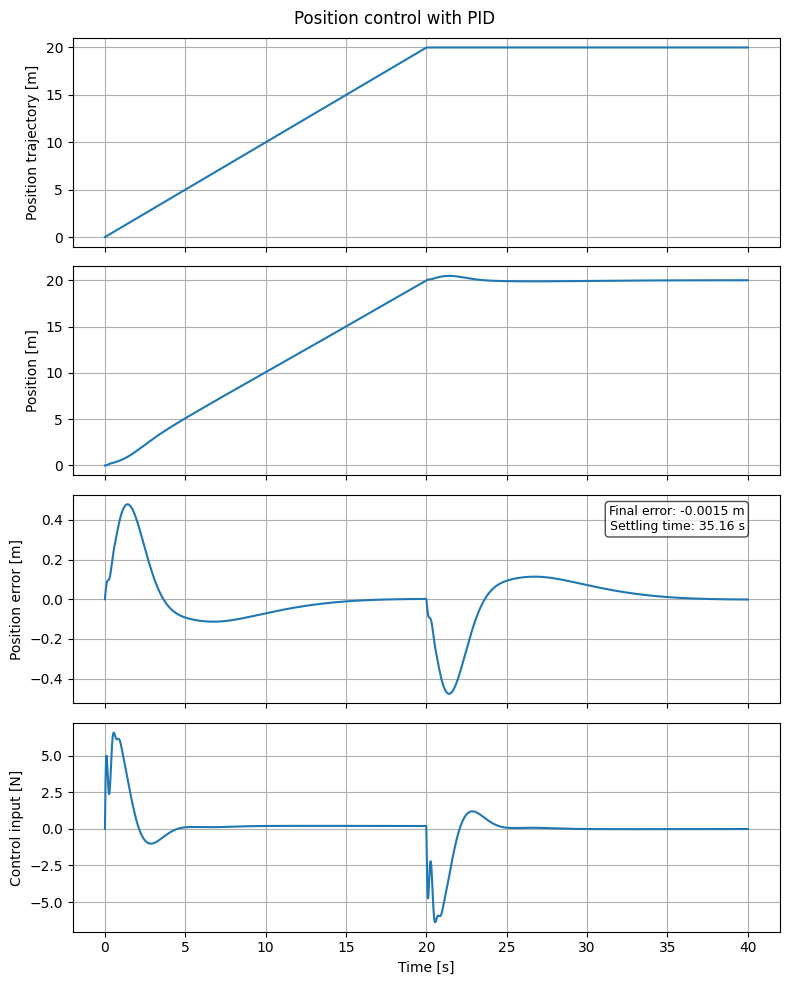

In [9]:

pid = controller.pid_tf(5,1,10)
y_out, _ =controller.analyze_pid_control(cable_car_f2x,pid)

*Let us analyze the other states that are not controlled by the PID.*


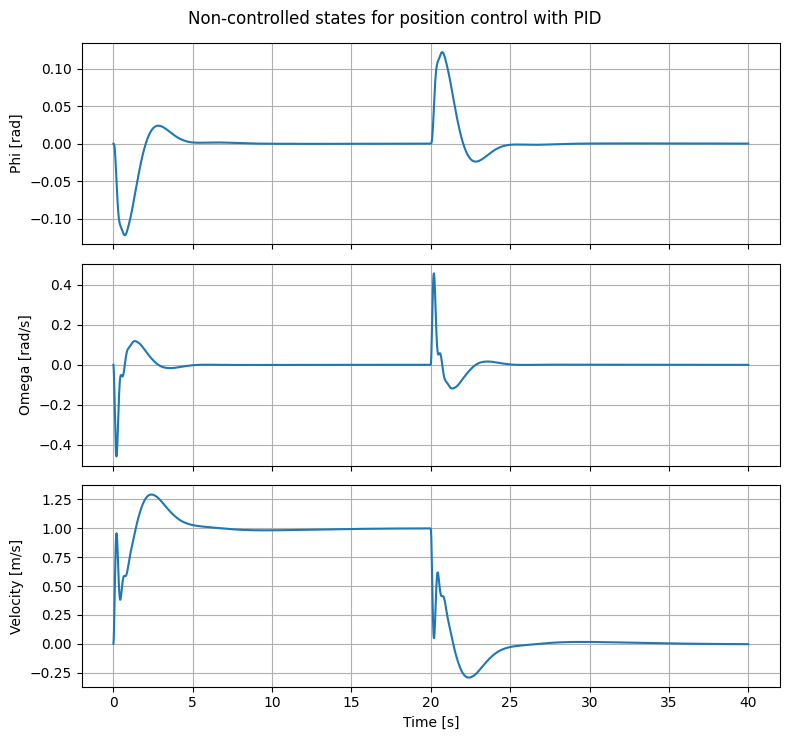

In [10]:
controller.analyze_pid_misc_states(pid, cablecar_sys_linear, controller.DEFAULT_POS_TRAJECTORY-y_out)

*Have we derived a properly working position control system?*

### Analyzing the PID using root-locus curve

What can we derive from the root locus curve? Will the performance improve if we increase all PID gains equally?

In [11]:
open_loop = cable_car_f2x*pid


*Poles*

In [12]:
open_loop.poles()

array([-10.        +0.j        ,  -0.66773799+7.03307159j,
        -0.66773799-7.03307159j,  -0.03572267+0.j        ,
         0.        +0.j        ,   0.        +0.j        ])

*Zeros*

In [13]:
open_loop.zeros()

array([-4.09269328e+15+0.j        , -4.95029891e-02+2.21412628j,
       -4.95029891e-02-2.21412628j, -2.42857144e-01+0.19041666j,
       -2.42857144e-01-0.19041666j])

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


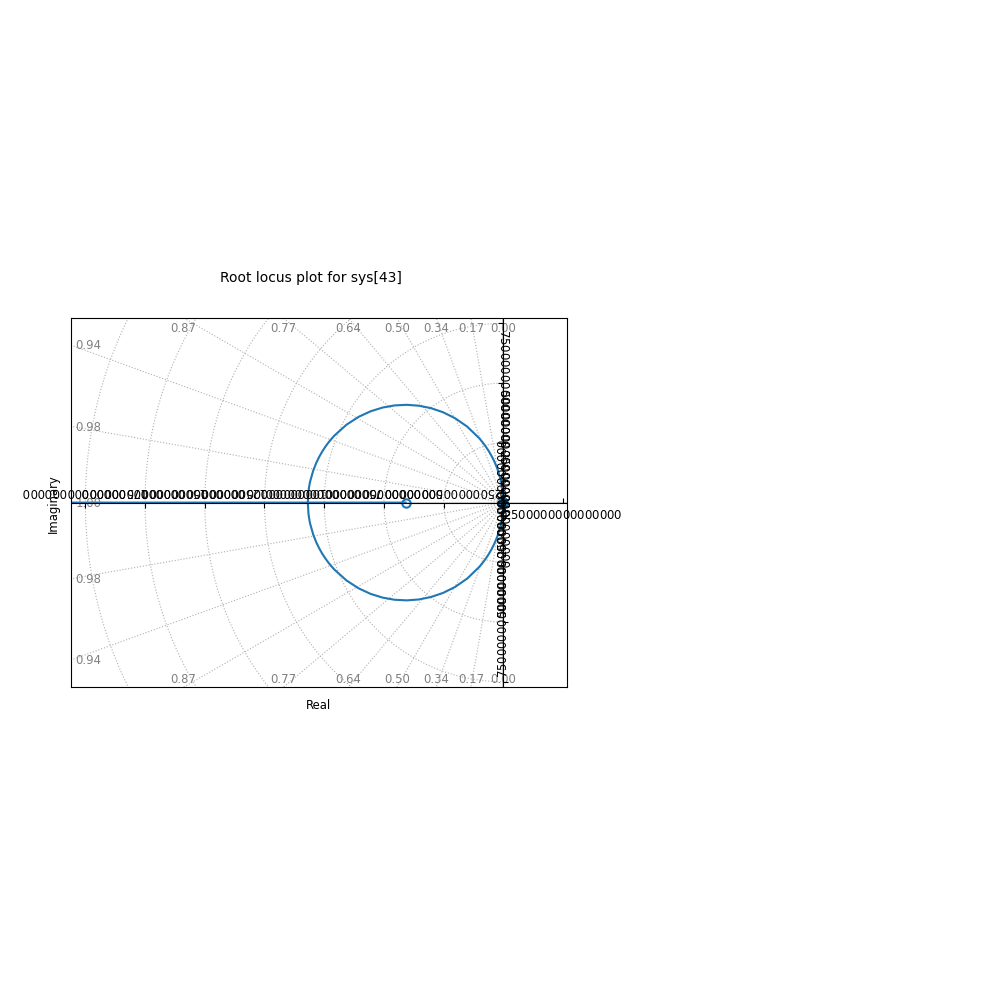

In [14]:
ct.rlocus(open_loop)

#### Conclusion

It is difficult to tune the control performance using only pole placement because the relationship between poles and performance (e.g., overshoot and settling time) is not straightforward.

### Deployment of state-feedback controller using LQR

Now, let's try devising a more effective controller using an optimal state-feedback controller. 

#### First we need to check if the system is controllable

In [15]:
# Controllability matrix
sys = cablecar_sys_linear
Co, rank_Co = controller.check_controllability(sys)

Controllability Matrix:
 [[   0.           -0.90872447    1.24604178   43.68919283]
 [  -0.90872447    1.24604178   43.68919283 -120.53573398]
 [   0.            1.81752093   -2.31223681  -78.71400005]
 [   1.81752093   -2.31223681  -78.71400005  220.20602022]]
Rank: 4, System order: 4
✅ Controllable


*Conclusion:* Fortunately, the system is controllable. Therefore, we can begin designing our LQR controller. 

#### LQR design

The LQR optimization problem

$$\begin{align}  \min_\mathbf{u} J=\int_0^\infty \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{u}^\top \mathbf{R} \mathbf{u} \; \text{dt}\\
s.t.  \\
\dot{\mathbf{x}} = \mathbf{A}x+Bu \\
\mathbf{Q}=\mathbf{Q}^\top \succeq 0, \mathbf{R}=\mathbf{R}^\top \succ 0\\
\end{align}$$

In [16]:
Q = np.eye(sys.A.shape[0])
R = 1
clsys, K, S, E =controller.compute_lqr(sys, Q, R)
resp_lqr = controller.resp_for_input(clsys)

c:\GitFolder\ControlSystems\.venv\Lib\site-packages\control\statefbk.py:779: UserWarning: cannot verify system output is system state
  warnings.warn("cannot verify system output is system state")


*Analyze the position control and its input*

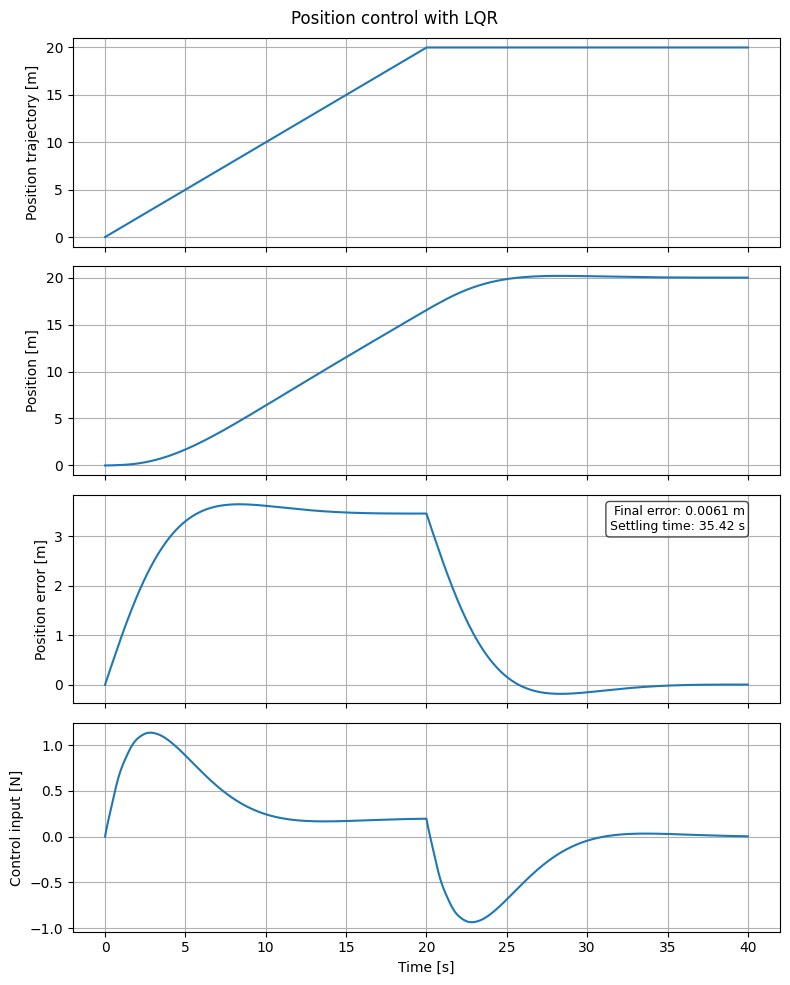

In [17]:
controller.analyze_lqr_control(resp_lqr)


*Analyze the other output states*

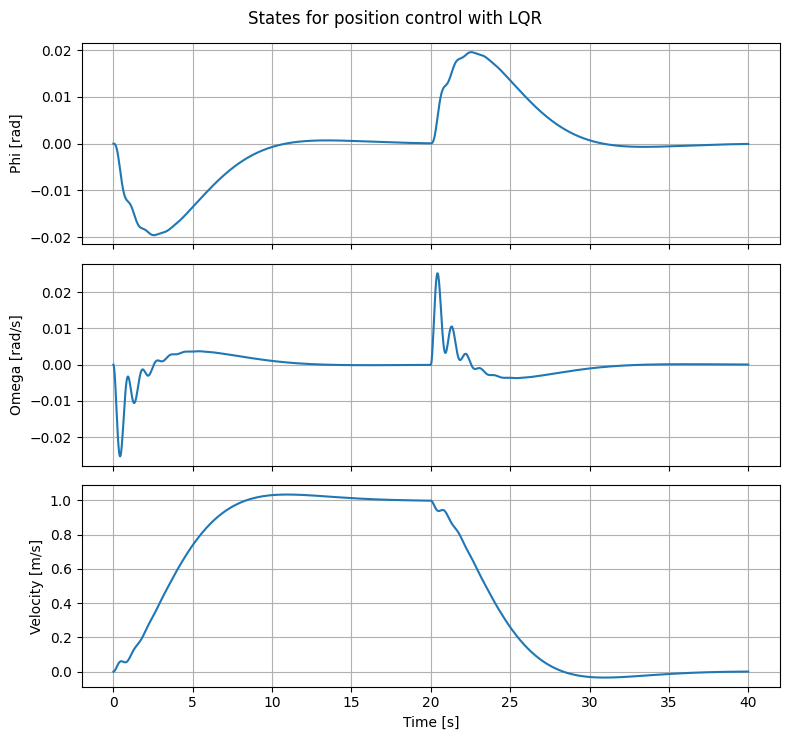

In [26]:
controller.analyze_lqr_misc_states(resp_lqr)

*Are you satisfied with the controller's performance?* If not, change the $Q$ and $R$ matrices!